In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from typing import Optional, List, TypeVar, Union
from pathlib import Path
from torch.utils.data import Dataset
import rasterio
from tqdm import tqdm
import numpy as np
import cv2
import warnings
from segmentation.config import Configs as CFG
from segmentation.scr.utils.rle_coding import *
from segmentation.scr.tilling_loader import random_sub_df
import matplotlib.pyplot as plt
from segmentation.scr.utils.transforms import get_transform
import albumentations as A


PandasDataFrame = TypeVar('pandas.core.frame.DataFrame')

C:\Users\123\AppData\Local\Temp\ipykernel_15112\142747098.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv(CFG.path_df_kidney_1_til)

In [3]:
train_transform = get_transform(transform_type='weak')

In [4]:
class Tilling_loader(Dataset):
    """Creating a dataloader for image tiling
    """

    def __init__(self,
                 name_data: str,
                 path_to_df: str,
                 use_random_sub: bool = False,
                 empty_tile_pct: int = 0,
                 sample_limit :Optional[int] = None,
                 transform=None

                 ):
        super().__init__()
        self.name_data = name_data
        self.path_to_df = Path(path_to_df)
        self.use_random_sub = use_random_sub
        self.empty_tile_pct = empty_tile_pct
        self.sample_limit = sample_limit
        self.transform = transform

        df = pd.read_csv(self.path_to_df)
        if self.use_random_sub:
            self.df = random_sub_df(df=df, sample_limit=self.sample_limit,
                                    empty_tile_pct=self.empty_tile_pct)
        else:
            self.df = df

    def __len__(self) -> int:
        return self.df.shape[0]

    def __getitem__(self, idx) -> tuple:
        img_path, lb_path, is_empty, bbx, _, size = self.df.iloc[idx, :].values
        gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.uint8)
        img = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB) #(H,W ,C)
        mask = cv2.imread(lb_path, cv2.IMREAD_GRAYSCALE).astype('float32') / 255.0
        if self.transform:   
            augmented = self.transform(image=img,mask=mask)
            img,mask = augmented['image'],augmented['mask']
        

        return img,mask, is_empty, bbx, size


data_loader = Tilling_loader(
    name_data='kidney_1_tilling',
    path_to_df='data\\kidney_1_tilling.csv',
    use_random_sub=True,
    empty_tile_pct=10,
    sample_limit=20,
    transform = None#train_transform
)

20
Dataset contains 1528 empty and 12146 non-empty tiles.
Sample 2 empty and 18 non-empty tiles.


In [5]:
data_loader.df['is_empty'].value_counts(normalize=True)

is_empty
False    0.9
True     0.1
Name: proportion, dtype: float64

In [ ]:
for i in range(len(data_loader)):
    x = data_loader[i]

In [ ]:
img, mask, is_empty, bbx, size = data_loader[3]

In [ ]:
#gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.uint8)
#img = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB) #(H,W ,C)
#mask = cv2.imread(lb_path, cv2.IMREAD_GRAYSCALE).astype('float32') / 255.0        



In [6]:
train_transform = get_transform(transform_type='weak')

img, mask, is_empty, bbx, size = data_loader[3]
augmented = train_transform(image=img,mask=mask)
img,mask = augmented['image'],augmented['mask']

In [7]:
train_transform = get_transform(transform_type=None)
img, mask, is_empty, bbx, size = data_loader[3]

#augmented = train_transform(image=img,mask=mask)
##img,mask = augmented['image'],augmented['mask']

In [30]:
from segmentation.scr.utils.transforms import get_transform

In [31]:
train_transform = get_transform(transform_type='weak')

img, mask, is_empty, bbx, size = data_loader[3]
augmented = train_transform(image=img,mask=mask)
img,mask = augmented['image'],augmented['mask']

In [113]:
from segmentation.config import Configs as CFG
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


train_transform = A.Compose(
            [
                A.VerticalFlip(p=CFG.p_rot),
                A.HorizontalFlip(p=CFG.p_rot),
                A.RandomRotate90(p=CFG.p_rot),
                A.ElasticTransform(
                    alpha=60, sigma=190 * 0.05, alpha_affine=2, p=CFG.p_aug
                ),
                
                A.RandomBrightnessContrast(),
                A.CLAHE(clip_limit=5
                    ),
                ToTensorV2(p=1),
            ],
            p=1,
        )

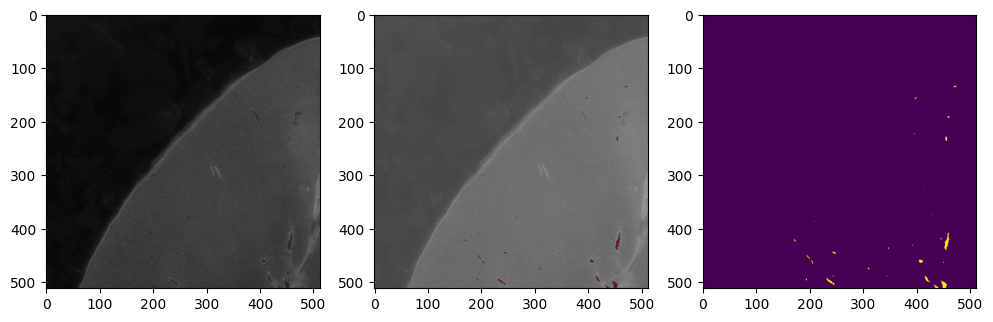

In [117]:
img, mask, is_empty, bbx, size = data_loader[8]
augmented = train_transform(image=img,mask=mask)
img,mask = augmented['image'],augmented['mask']


fig, axarr = plt.subplots(ncols=3, figsize=(12, 6))
axarr[0].imshow(torch.permute(img, (1,2,0)).numpy(), cmap="gray")
axarr[1].imshow(color.label2rgb(mask.numpy(), torch.permute(img, (1,2,0)).numpy(), bg_label=0, bg_color=(1.,1.,1.), alpha=0.25))
axarr[2].imshow(mask, vmin=0, interpolation='antialiased', interpolation_stage='rgba')

In [ ]:
from skimage import color
gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.uint8)
img = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB) #(H,W ,C)
mask = cv2.imread(lb_path, cv2.IMREAD_GRAYSCALE).astype('float32') / 255.0   
#augmented = train_transform(image=img,mask=mask)
#img,mask = augmented['image'],augmented['mask']

fig, axarr = plt.subplots(ncols=3, figsize=(12, 6))
axarr[0].imshow(img, cmap="gray")
axarr[1].imshow(color.label2rgb(mask, img, bg_label=0, bg_color=(1.,1.,1.), alpha=0.25))
axarr[2].imshow(mask, vmin=0, interpolation='antialiased', interpolation_stage='rgba')

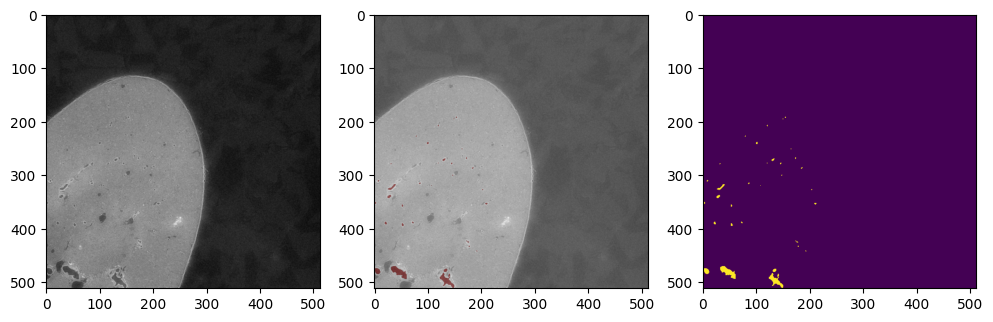

In [56]:
from skimage import color
fig, axarr = plt.subplots(ncols=3, figsize=(12, 6))
axarr[0].imshow(img, cmap="gray")
axarr[1].imshow(color.label2rgb(mask, img, bg_label=0, bg_color=(1.,1.,1.), alpha=0.25))
axarr[2].imshow(mask, vmin=0, interpolation='antialiased', interpolation_stage='rgba')

In [ ]:
img.shape

In [ ]:
img[None, :,:].shape

In [ ]:
gray = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
#img1 = np.tile(img1[...,None], [1, 1, 3]) 
backtorgb = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)

In [ ]:
backtorgb.shape

In [ ]:
data_loader.df

In [ ]:
len(data_loader)

In [ ]:
    name_data='kidney_1_tilling',
    strong_empty=False,
    path_img_dir=CFG.path_img_kidney1,
                         path_lb_dir=CFG.path_lb_kidney1,
                         cache_dir=CFG.cache_dir 

In [ ]:
type(pd.DataFrame())

In [ ]:
new_df['is_empty'].value_counts(normalize=True)

In [ ]:
df_empty = df[df['is_empty'] == True].sample(1000)
df_no_empty = df[df['is_empty'] == False].sample(6000)
frames = [df_empty, df_no_empty]
pd.concat(frames).sort_index()

In [ ]:
800 / 7200

In [ ]:
1528/ (1528+3565)

In [ ]:
empty_tiles = df[df['is_empty'] == True].index.values

In [ ]:
num_empty_tiles_to_sample 

In [ ]:
np.random.choice(empty_tiles, min(num_empty_tiles_to_sample, len(empty_tiles)), replace=False)

In [ ]:
df[df['is_empty'] == True].index.values

In [ ]:
df = pd.read_csv(CFG.path_df_kidney_1_til)

In [ ]:
df['is_empty'].value_counts(normalize=True)[False]

In [ ]:
num_tiles = df.shape[0]
num_tiles 

In [ ]:
empty_tile_pct = 20
num_empty_tiles_to_sample = int(num_tiles * empty_tile_pct / 100)
num_pos_tiles_to_sample = int(num_tiles * (1 - empty_tile_pct / 100))

In [ ]:
num_empty_tiles_to_sample

In [ ]:
num_pos_tiles_to_sample

In [ ]:
1367 + 12306

In [ ]:
np.random.choice(10, min(5, 4), replace=False)

In [ ]:
num_empty_tiles_to_sample = int(self.sample_limit * self.empty_tile_pct)
            num_pos_tiles_to_sample = int(self.sample_limit * (1 - self.empty_tile_pct))

            empty_idxs_to_sample = np.random.choice(len(empty_tiles), min(num_empty_tiles_to_sample, len(empty_tiles)), replace=False)
            pos_idxs_to_sample = np.random.choice(len(populated_tiles), min(num_pos_tiles_to_sample, len(populated_tiles)), replace=False)

            neg_samples = list(map(empty_tiles.__getitem__, empty_idxs_to_sample))
            pos_samples = list(map(populated_tiles.__getitem__, pos_idxs_to_sample))

            new_samples = pos_samples + neg_samples

            self.samples = new_samples
            if self.empty_tile_pct == 0.0:
                print(f'Dropped {empty} empty tiles.')
            print(f'Dataset contains {len(neg_samples)} empty and {len(pos_samples)} non-empty tile

In [ ]:
df